Learning How Reverse Mode Auto Differentiation Works

In [2]:
import math

In [449]:
class Value():
    def __init__(self, data, parents=(), op='', label='', updatable=False): 
        self.data = data
        self.parents = parents
        self.grad = 0
        self.op = op
        self.label = label
        self.updatable = updatable
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  
        out = Value(self.data + other.data, (self, other), "+")    
        return out
    
    def __pow__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data**other.data, (self, other), f"**")
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  
        out = Value(self.data - other.data, (self, other), "-")
        return out

    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  
        out = Value(self.data / other.data, (self, other), "/")
        return out

    def __neg__(self, other):
        return self * -1
        
    def relu(self):
        out = Value(max(0, self.data), (self,), "relu")
        return out
    
    def sigmoid(self):
        out = Value(1 / (1 + math.exp(-self.data)), (self,), "sigmoid")
        return out

    def __repr__(self): 
        return f"Value(data: {self.data}, label: {self.label})"

    def backward(self):
        if self.op == "*":
            self.parents[0].grad += self.parents[1].data * self.grad
            self.parents[1].grad += self.parents[0].data * self.grad
        elif self.op == "+":
            # addition simply propogates our gradients to parents
            self.parents[0].grad += 1 * self.grad
            self.parents[1].grad += 1 * self.grad
        elif self.op == "-":
            self.parents[0].grad += 1 * self.grad
            self.parents[1].grad += -1 * self.grad
        elif self.op == "/":
            self.parents[0].grad += 1/self.parents[1].data*self.grad
            self.parents[1].grad += -self.parents[0].data / (self.parents[1].data ** 2) * self.grad
        elif self.op == "relu":
            self.parents[0].grad += 0 if self.data == 0 else 1 
        elif self.op == "sigmoid":
            self.parents[0].grad += math.exp(-self.data) / (1+math.exp(-self.data)) ** 2
        elif self.op == "**":
            self.parents[0].grad += (self.parents[1].data * self.parents[0].data**(self.parents[1].data - 1))* self.grad
        
    def backpropogate(self):
        self.grad = 1

        # Keep track of nodes we visit so we don't backpropogate through them twice
        visited = set()
        def _backpropogate(node):
            if node in visited:
                return
            visited.add(node)

            node.backward()            
            for parent in node.parents:
                _backpropogate(parent)
                    
        _backpropogate(self)
    
    def zero_grad(self):
        self.grad = 0

        for parent in self.parents:
            parent.zero_grad()
    
    def update_params(self, learning_rate):
        visited = set() 
        def _update(node, learning_rate):
            if node in visited:
                return
            
            visited.add(node)

            if node.updatable:
                node.data -= learning_rate * node.grad
            
            for parent in node.parents:
                _update(parent, learning_rate)
        
        _update(self, learning_rate)

In [450]:
a = Value(3.0) 
a.label = "a"
b = Value(5.0)
b.label = "b"
c = Value(6.0)
c.label = "c"
d = a + 3
d.label = "d"

e = c * d
e.label = "e"
f = Value(2.0)
f.label = "f"

l = e * f 
l.label = "l"


g = l * l
g.label = "g"
h = g * Value(2.0, label="y")
h.label = "h"
i = h - Value(1.0, label="x")
i.label = "i"
j = i / Value(5.0, label="k")
j.label = "j"
loss =  j.sigmoid() 
loss.label = "loss"

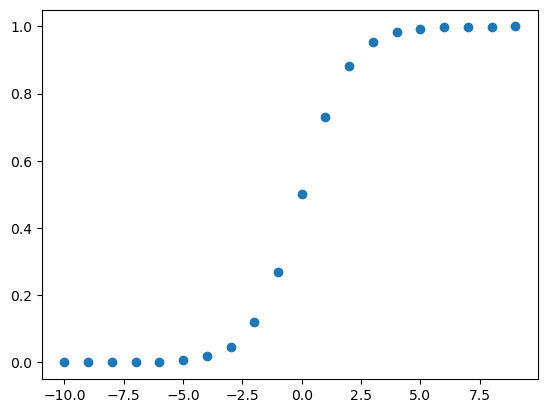

In [135]:
# Proof that sigmoid works
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-10, 10, 1)
y = [Value(i).sigmoid().data for i in x]

plt.scatter(x,y)


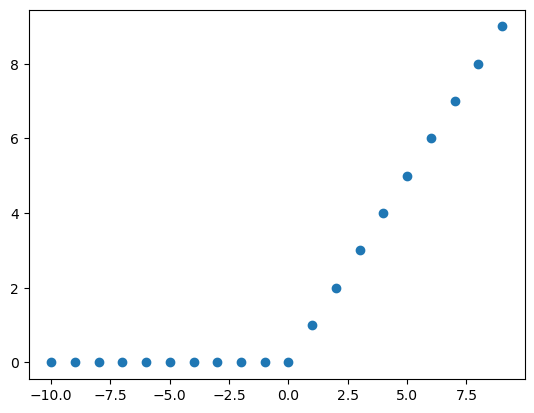

In [136]:
# Proof that relu works
x = np.arange(-10, 10, 1)
y = [Value(i).relu().data for i in x]
plt.scatter(x, y)

In [601]:
import graphviz 

def mapviz(root, dot):
    dot.node(root.label, f"{root.label} | {root.data: .2f} | {root.grad: .2f}") 
    
    if (root.op):
        dot.node(root.label + root.op, root.op)
        dot.edge(root.label, root.label + root.op)

    tmp = None
    for parent in root.parents:
        dot.node(parent.label, f"{parent.label} | {parent.data} | {parent.grad}")
        dot.edge(root.label + root.op, parent.label)
        if parent != tmp:
            mapviz(parent, dot)
        tmp = parent


In [602]:
# l = e*f
# dl/dl = 1
# dl/de = f = 2.0 
# dl/df = e = 48.0
# dl/dc = dl/de * de/dc = e.grad * d.data = 2.0 * 8 = 16
# dl/dd = dl/de * de/dd = e.grad * c.data = 2.0 * 6 = 12
# dl/da = dl/dd * dd/da = d.grad * b.data = 12 * 1 = 12
# dl/db = dl/dd * dd/db = d.grad * a.data = 12 * 1 = 12

# l.grad = 1.0
# e.grad = 2.0
# f.grad = 48.0
# c.grad = 384
# d.grad = 288
# a.grad = 288
# b.grad = 288

# l.grad = 1
# l.backward()
# e.backward()
# d.backward()


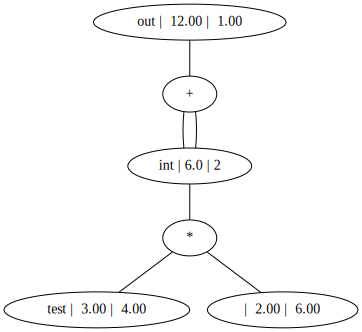

In [603]:
test = Value(3.0)
test.label = "test"

int_ = test * 2.0
int_.label = "int"

out = int_ + int_
out.label = "out"

out.backpropogate()

graph = graphviz.Graph('back prop test') 
mapviz(out, graph)
graph

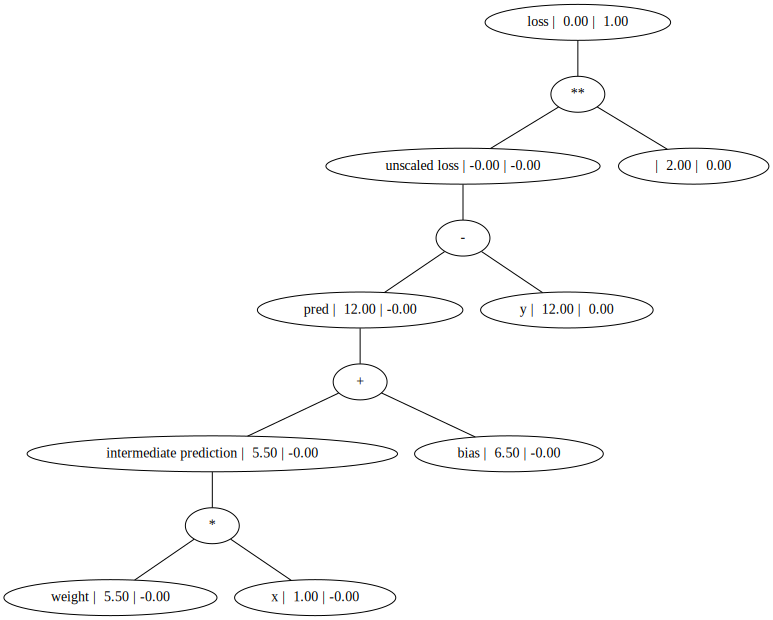

In [604]:
loss.backpropogate()
# loss.zero_grad() test for zero grad

graph = graphviz.Graph('back prop') 
mapviz(loss, graph)
graph

Let's see if we can train a model to fit a very simple relation with 1 data point (1, 12) using a basic linear regression model

In [611]:
# basic data set
import random
# basic data set
x = Value(1)
x.label = "x"
y = Value(12)
y.label = "y"

# weight and bias for linear regression model
weight = Value(1, label="weight", updatable=True)
bias = Value(2, label="bias", updatable=True)

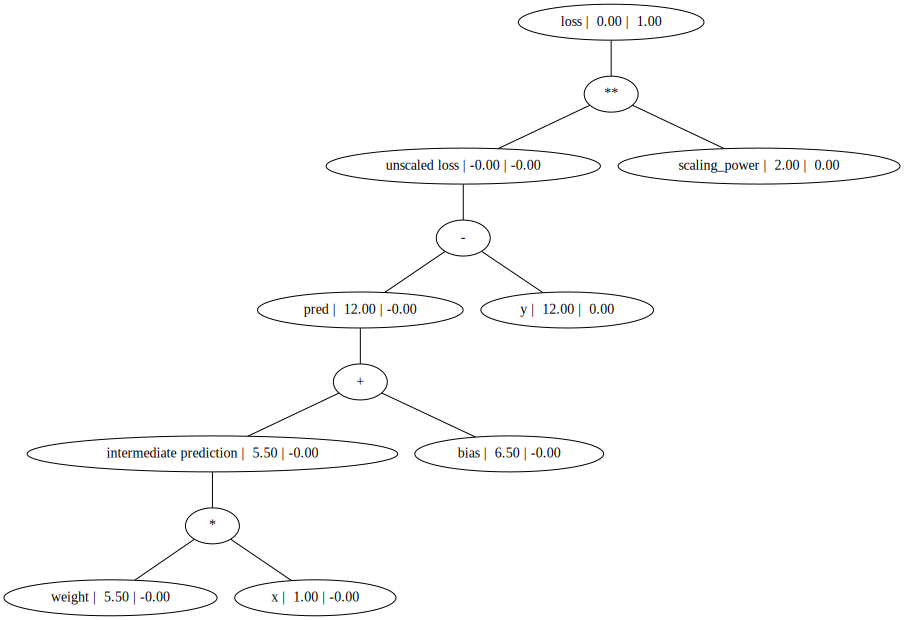

In [612]:
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    preds_int = weight * x
    preds_int.label = "intermediate prediction"
    preds = preds_int + bias
    preds.label = "pred"
    loss_unscaled = (preds - y) 
    loss_unscaled.label = "unscaled loss"
    # mean square loss
    loss = loss_unscaled ** Value(2, label="scaling_power")
    losses.append(loss.data)
    loss.label = "loss"
    loss.backpropogate()
    loss.update_params(0.1)
    graph = graphviz.Graph('example') 
    mapviz(loss, graph)
    loss.zero_grad()
# print(loss_test)

graph

Text(0.5, 1.0, 'Loss per Epoch')

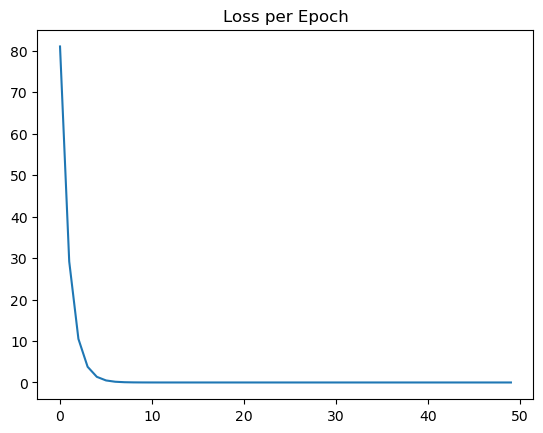

In [620]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Loss per Epoch")